In [1]:
print("Instructors: Evimaria Terzi, Sanaz Bahargam")
print("Team Members: Fan Li, Duomin Ji")

Instructors: Evimaria Terzi, Sanaz Bahargam
Team Members: Fan Li, Duomin Ji


In [2]:
print("Background:")
print("Machine Learning has been a widely researched topic these years. It studies the algorithms that could help computers 'learn' things and make predictions on the data that we are interested in. People in our team are all film lovers and we assume that is the case for computers as well. Thus we conduct this survey on three different machine learning models, including Support Vector Machine (SVM), Decision Tress (DT) and K-nearest Neighboring (KNN) and train the computer to learn about films and then predict film ratings.")
print()
print("The Problem and The Goal:")
print("Best Rating-related Attributes: given a set of features of the film, find out the ones that would help the computer predict the film’s rating most accurately (films are rated on a scale of 1-10).")
print()
print("Datasets:") 
print("Data 1: 'films.csv' was scraped by our team from 'www.imdb.com'; it consists of information of over 5,500 popular films throughout the years from 1898 to 2016.")
print("Data 2: 'movie_metadata.csv' is provided by 'www.kaggle.com', an open source website, and it is a more diverse dataset containing extra information of over 5,000 films (most are different films from films in dataset 1).")
print()
print("The comments and the print statements will walk you through this project and help you understand exactly what we did.")

Background:
Machine Learning has been a widely researched topic these years. It studies the algorithms that could help computers 'learn' things and make predictions on the data that we are interested in. People in our team are all film lovers and we assume that is the case for computers as well. Thus we conduct this survey on three different machine learning models, including Support Vector Machine (SVM), Decision Tress (DT) and K-nearest Neighboring (KNN) and train the computer to learn about films and then predict film ratings.

The Problem and The Goal:
Best Rating-related Attributes: given a set of features of the film, find out the ones that would help the computer predict the film’s rating most accurately (films are rated on a scale of 1-10).

Datasets:
Data 1: 'films.csv' was scraped by our team from 'www.imdb.com'; it consists of information of over 5,500 popular films throughout the years from 1898 to 2016.
Data 2: 'movie_metadata.csv' is provided by 'www.kaggle.com', an open 

In [9]:
## import packages
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import requests
import time
import random
import csv
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
from scipy.stats import linregress
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns 
import pydotplus

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [133]:
## Phase 1: Data Collection
## Create a film.csv file where we will store our data from imdb
col = ['Name', 'Year', 'Country', 'Genre', 'Rating', 'Metascore', 'Runtime', 'Sound_mix', 'Color', 'Budget' , 'Gross', 'Director', 'Stars']
with open('films-2.csv','w') as f:
    w = csv.writer(f)
    w.writerow(col)
    print("write success...")
    f.close()

write success...


In [3]:
## The function for scraping information we need from imdb
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.76 Safari/537.36"
headers = {'User-Agent' : user_agent}

def scrape_imdb_movies(page_url, y):
    driver = webdriver.Chrome('/Users/fanli/Downloads/chromedriver')
    driver.set_window_position(-10000,0)
    driver.get(page_url)
    year = str(y)
    results = driver.find_elements_by_class_name("lister-item-content")
    if results == []:
        print('No films released in year ' + year)
        driver.quit()
        time.sleep(15)
        return
    
    for result in results:
        film_soup = title_and_link = title = link = genres = country = sound_mix = color = director = stars = ""
        budget = gross = 0
        runtime = '0 min'
        current_film = []
        summary_items = ""
        ## get the info which we can get from the list page
        title_and_link = result.find_element_by_xpath('.//h3/a')
        title = title_and_link.text
        link = title_and_link.get_attribute('href')

        ## get some other info from the film page
        film_soup = bs(requests.get(link, headers = headers).content,'html.parser') 
        time.sleep(1)
        try:
            rating = film_soup.find('span', {'itemprop': 'ratingValue'}).text
        except:
            rating = 0
        try:
            metascore = int(film_soup.find("div", class_=lambda value: value and value.startswith("metacriticScore")).text)
        except:
            metascore = 0
        
        info_list = film_soup.find('div', {'id': 'titleDetails'}).find_all('div', class_='txt-block')
        for info in info_list:
            if info.find('h4', text='Country:'):
                country = info.text.split("\n")[2]
            elif info.find('h4', text='Runtime:'):
                runtime = info.text.split("\n")[2]
            elif info.find('h4', text='Sound Mix:'):
                sound_mix = info.text.split("\n")[2]
            elif info.find('h4', text='Color:'):
                color = info.text.split("\n")[2]
            elif info.find('h4', text='Budget:'):
                budget = info.text.split("\n")[1][15:]
            elif info.find('h4', text='Gross:'):
                gross = info.text.split("\n")[1][14:]
        
        try:
            genres = film_soup.find('div', {'itemprop': 'genre'}).find_all('a')
            temp = [genre.text for genre in genres]
            genres = ','.join(temp)
        except:
            genres = ' '
            
        try:
            summary_items = film_soup.find_all("div", class_="credit_summary_item")
            for summary_item in summary_items:
                if summary_item.find('h4', text='Director:'):
                    director = summary_item.text.split("\n")[3]
        except:
            summary_items = director = ""
        
        try:
            stars = film_soup.find_all('span', {'itemprop': 'actors'}, {'itemprop': 'name'})
            temp2 = [star.find('a').text for star in stars]
            stars = ','.join(temp2)
        except:
            stars = ""
            
        current_film.append(title)
        current_film.append(year)
        current_film.append(country)
        current_film.append(genres)
        current_film.append(rating)
        current_film.append(metascore)
        current_film.append(runtime)
        current_film.append(sound_mix)
        current_film.append(color)
        current_film.append(budget)
        current_film.append(gross)
        current_film.append(director)
        current_film.append(stars)
        print(current_film)
    
        with open('films-2.csv','a') as f:
            w = csv.writer(f)
            w.writerow(current_film)
            print('''\'''' + title + "\' written successfully")
            f.close()
        time.sleep(15)
        print()
        
    print('Films released in ' + year + ' written in films.csv')
    time.sleep(15)
    driver.quit()

In [136]:
## We will scrape 50 films for each year
## Starting from year 1898
## Can't make too many requests per day ( to avoid getting banned from imdb )

## films (year 1898 - 1950)
year_url1 = "http://www.imdb.com/search/title?year="
year_url2 = "&title_type=feature&sort=moviemeter,asc"
for i in range(1898,1951):
    current_url = year_url1 + str(i) + ',' + str(i) + year_url2
    scrape_imdb_movies(current_url, i)
print()
print("1898 - 1950 finished")

['Can Can', '1898', 'USA', ' ', '5.9', 0, '0 min', 'Silent', ' Black and White', 0, 0, '', 'Mlle. Fraidora']
'Can Can' written successfully

["Torpedo Boat, 'Dupont'", '1898', 'USA', ' ', '3.7', 0, '0 min', 'Silent', ' Black and White', 0, 0, '', '']
'Torpedo Boat, 'Dupont'' written successfully

['Bombardment of Matanzas', '1898', 'USA', ' ', '3.8', 0, '0 min', 'Silent', ' Black and White', 0, 0, 'Edward Amet ', '']
'Bombardment of Matanzas' written successfully

['Pea-Hulling Machine', '1898', 'USA', ' ', '4.3', 0, '0 min', 'Silent', ' Black and White', 0, 0, '', '']
'Pea-Hulling Machine' written successfully

['Freedom of Cuba', '1898', 'USA', ' ', '4.4', 0, '0 min', 'Silent', ' Black and White', 0, 0, 'Edward Amet ', '']
'Freedom of Cuba' written successfully

["S.S. 'Coptic'", '1898', 'USA', ' ', '3.6', 0, '0 min', 'Silent', ' Black and White', 0, 0, '', '']
'S.S. 'Coptic'' written successfully

['Highland Fling', '1898', 'UK', ' ', '4.2', 0, '0 min', 'Silent', ' Black and White',

In [137]:
## films (year 1951 - 1960)
year_url1 = "http://www.imdb.com/search/title?year="
year_url2 = "&title_type=feature&sort=moviemeter,asc"
for i in range(1951,1961):
    current_url = year_url1 + str(i) + ',' + str(i) + year_url2
    scrape_imdb_movies(current_url, i)
print()
print("1951 - 1960 finished")

['A Streetcar Named Desire', '1951', 'USA', ' Drama', '8.0', 0, '122 min', 'Mono', ' Black and White', '$1,800,000        ', 0, 'Elia Kazan ', 'Vivien Leigh,Marlon Brando,Kim Hunter']
'A Streetcar Named Desire' written successfully

['A Place in the Sun', '1951', 'USA', ' Drama, Romance', '7.8', 0, '122 min', 'Mono', ' Black and White', '$2,295,304        ', 0, 'George Stevens ', 'Montgomery Clift,Elizabeth Taylor,Shelley Winters']
'A Place in the Sun' written successfully

['Alice in Wonderland', '1951', 'USA', ' Animation, Adventure, Family, Fantasy, Musical', '7.4', 0, '75 min', 'Mono', 'Color', '$3,000,000        ', 0, '', 'Kathryn Beaumont,Ed Wynn,Richard Haydn']
'Alice in Wonderland' written successfully

['An American in Paris', '1951', 'USA', ' Drama, Musical, Romance', '7.2', 0, '113 min', 'Mono', 'Color', '$2,723,903        ', '$4,500,000        ', 'Vincente Minnelli ', 'Gene Kelly,Leslie Caron,Oscar Levant']
'An American in Paris' written successfully

['The Day the Earth St

In [4]:
## films (year 1961 - 2016)
year_url1 = "http://www.imdb.com/search/title?year="
year_url2 = "&title_type=feature&sort=moviemeter,asc"
for i in range(1961,2017):
    current_url = year_url1 + str(i) + ',' + str(i) + year_url2
    scrape_imdb_movies(current_url, i)
print()
print("1961 - 2016 finished")

["Breakfast at Tiffany's", '1961', 'USA', ' Comedy, Drama, Romance', '7.7', 76, '115 min', 'Mono', 'Color', '$2,500,000        ', 0, 'Blake Edwards ', 'Audrey Hepburn,George Peppard,Patricia Neal']
'Breakfast at Tiffany's' written successfully

['Judgment at Nuremberg', '1961', 'USA', ' Drama, War', '8.3', 0, '186 min', 'Mono', ' Black and White', '$3,000,000        ', 0, 'Stanley Kramer ', 'Spencer Tracy,Burt Lancaster,Richard Widmark']
'Judgment at Nuremberg' written successfully

['West Side Story', '1961', 'USA', ' Crime, Drama, Musical, Romance, Thriller', '7.6', 0, '152 min', '4-Track Stereo', 'Color', '$6,000,000        ', '$43,650,000        ', '', 'Natalie Wood,George Chakiris,Richard Beymer']
'West Side Story' written successfully

['Splendor in the Grass', '1961', 'USA', ' Drama, Romance', '7.8', 0, '124 min', 'Mono', 'Color', 0, 0, 'Elia Kazan ', 'Natalie Wood,Warren Beatty,Pat Hingle']
'Splendor in the Grass' written successfully

['Reptilicus', '1961', 'Denmark', ' Action

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [5]:
## The internet connection failed here
## Have to start from 1971
## films (year 1971 - 2016)
year_url1 = "http://www.imdb.com/search/title?year="
year_url2 = "&title_type=feature&sort=moviemeter,asc"
for i in range(1971,2017):
    current_url = year_url1 + str(i) + ',' + str(i) + year_url2
    scrape_imdb_movies(current_url, i)
print()
print("1971 - 2016 finished")

['The Beguiled', '1971', 'USA', ' Drama, Thriller, Western', '7.2', 0, '105 min', 'Mono', 'Color', 0, 0, 'Don Siegel (as Donald Siegel)            ', 'Clint Eastwood,Geraldine Page,Elizabeth Hartman']
'The Beguiled' written successfully

['A Clockwork Orange', '1971', 'UK', ' Crime, Drama, Sci-Fi', '8.3', 78, '136 min', 'Dolby Digital', ' Black and White', '$2,200,000        ', 0, 'Stanley Kubrick ', 'Malcolm McDowell,Patrick Magee,Michael Bates']
'A Clockwork Orange' written successfully

['Willy Wonka & the Chocolate Factory', '1971', 'USA', ' Family, Fantasy, Musical', '7.8', 0, '100 min', '3 Channel Stereo', 'Color', '$3,000,000        ', 0, 'Mel Stuart ', 'Gene Wilder,Jack Albertson,Peter Ostrum']
'Willy Wonka & the Chocolate Factory' written successfully

['The Last Picture Show', '1971', 'USA', ' Drama', '8.1', 0, '118 min', 'Mono', ' Black and White', '$1,300,000        ', 0, 'Peter Bogdanovich ', 'Timothy Bottoms,Jeff Bridges,Cybill Shepherd']
'The Last Picture Show' written s

KeyboardInterrupt: 

In [4]:
## Same thing happened...
## films (year 2000 - 2006)
year_url1 = "http://www.imdb.com/search/title?year="
year_url2 = "&title_type=feature&sort=moviemeter,asc"
for i in range(2000,2007):
    current_url = year_url1 + str(i) + ',' + str(i) + year_url2
    scrape_imdb_movies(current_url, i)
print()
print("2000 - 2006 finished")

['Unbreakable', '2000', 'USA', ' Drama, Mystery, Sci-Fi, Thriller', '7.2', 62, '106 min', 'Dolby Digital EX', 'Color', '$75,000,000        ', '$94,999,143        ', 'M. Night Shyamalan ', 'Bruce Willis,Samuel L. Jackson,Robin Wright']
'Unbreakable' written successfully

['Gladiator', '2000', 'USA', ' Action, Adventure, Drama', '8.5', 64, '155 min', 'SDDS', 'Color', '$103,000,000        ', '$187,670,866        ', 'Ridley Scott ', 'Russell Crowe,Joaquin Phoenix,Connie Nielsen']
'Gladiator' written successfully

['American Psycho', '2000', 'USA', ' Crime, Drama', '7.6', 64, '102 min', 'Dolby Digital', 'Color', '$7,000,000        ', '$15,047,419        ', 'Mary Harron ', 'Christian Bale,Justin Theroux,Josh Lucas']
'American Psycho' written successfully

['Snatch', '2000', 'UK', ' Comedy, Crime', '8.3', 55, '104 min', 'Dolby Digital', 'Color', '£6,000,000        ', '$30,093,107        ', 'Guy Ritchie ', 'Jason Statham,Brad Pitt,Benicio Del Toro']
'Snatch' written successfully

['Requiem for

In [4]:
## Made too many requests per day
## Only two years to go, though
## films (year 2014 - 2016)
year_url1 = "http://www.imdb.com/search/title?year="
year_url2 = "&title_type=feature&sort=moviemeter,asc"
for i in range(2014,2017):
    current_url = year_url1 + str(i) + ',' + str(i) + year_url2
    scrape_imdb_movies(current_url, i)
print()
print("2014 - 2016 finished")

['Guardians of the Galaxy', '2014', 'USA', ' Action, Adventure, Sci-Fi', '8.1', 76, '121 min', 'Datasat', 'Color', '$170,000,000        ', '$333,130,696        ', 'James Gunn ', 'Chris Pratt,Vin Diesel,Bradley Cooper']
'Guardians of the Galaxy' written successfully

['Kingsman: The Secret Service', '2014', 'UK', ' Action, Adventure, Comedy, Thriller', '7.7', 58, '129 min', 'Dolby Atmos', 'Color', '$81,000,000        ', '$128,248,205        ', 'Matthew Vaughn ', 'Colin Firth,Taron Egerton,Samuel L. Jackson']
'Kingsman: The Secret Service' written successfully

['Interstellar', '2014', 'USA', ' Adventure, Drama, Sci-Fi', '8.6', 74, '169 min', 'Datasat', 'Color', '$165,000,000        ', '$187,991,439        ', 'Christopher Nolan ', 'Matthew McConaughey,Anne Hathaway,Jessica Chastain']
'Interstellar' written successfully

['John Wick', '2014', 'USA', ' Action, Crime, Thriller', '7.2', 68, '101 min', 'Dolby Digital', 'Color', '$20,000,000        ', '$42,996,986        ', '', 'Keanu Reeves,M

In [ ]:
## And at this point, we downloaded our second dataset from kaggle

In [135]:
##########

##########

In [10]:
## Phase 2: 
## Data Analysis
## import data (the first dataset only for now)
films = pd.read_csv('films.csv', encoding = "ISO-8859-1")
films.tail()

,Name,Year,Country,Genre,Rating,Metascore,Runtime,Sound_mix,Color,Budget,Gross,Director,Stars
5562,Silence,2016,USA,"Adventure, Drama, History",7.3,79,161 min,NaN,Color,"$46,000,000","$7,079,191",Martin Scorsese,"Andrew Garfield,Adam Driver,Liam Neeson"
5563,Independence Day: Resurgence,2016,USA,"Action, Adventure, Sci-Fi",5.3,32,120 min,Dolby Digital,Color,"$165,000,000","$103,137,295",Roland Emmerich,"Liam Hemsworth,Jeff Goldblum,Bill Pullman"
5564,The Autopsy of Jane Doe,2016,UK,"Horror, Mystery, Thriller",6.8,65,86 min,Dolby Atmos,Color,0,0,AndrÌ© Ì÷vredal,"Brian Cox,Emile Hirsch,Ophelia Lovibond"
5565,Manchester by the Sea,2016,USA,Drama,7.9,96,137 min,NaN,Color,"$8,500,000","$47,695,120",Kenneth Lonergan,"Casey Affleck,Michelle Williams,Kyle Chandler"
5566,Patriots Day,2016,Hong Kong,"Drama, History, Thriller",7.4,69,133 min,NaN,Color,"$45,000,000","$31,856,991",Peter Berg,"Mark Wahlberg,Michelle Monaghan,J.K. Simmons"


In [11]:
## There are some films that are missing some values
## We will remove all those data rows
print(films.shape)
copy = films
no_NA = copy.dropna()
print(films.shape)
print(no_NA.shape)
has_metascore = no_NA.drop(no_NA.index[no_NA.Metascore == 0])
print(has_metascore.shape)

(5567, 13)
(5567, 13)
(4887, 13)
(1375, 13)


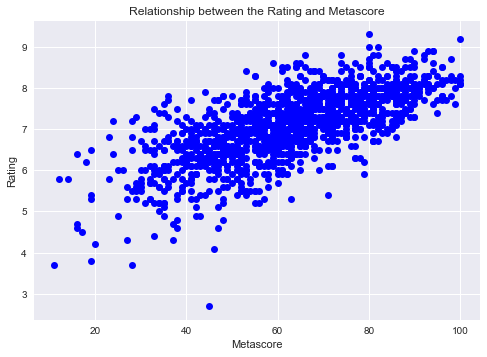

The Pearson Correlation: (0.70427493150150178, 1.5909105598631671e-206)

From the plot and the correlation between the audience ratings and the crtics', we can see that tht(ere is a relatively strong positive correlation between the two.
Now we would train our models to predict normal film viewers' ratings based merely on the critics ratings (metascore).


In [12]:
## Phase 2 - Experiment One 
## We want to know the relationship between the citics ratings (metascore) and the normal users ratings (rating/imdb score)
## some simple analysis of the data
## Relationship between the Rating and Metascore

xs = list(has_metascore['Metascore'])
ys = list(has_metascore['Rating'])
plt.plot(xs, ys, 'ro', color = 'b')
plt.xlabel('Metascore')
plt.ylabel('Rating')
plt.title('Relationship between the Rating and Metascore')
plt.show()
cor = pearsonr(xs,ys)
print("The Pearson Correlation: " + str(cor))
print()
print("From the plot and the correlation between the audience ratings and the crtics', we can see that tht(ere is a relatively strong positive correlation between the two.")
print("Now we would train our models to predict normal film viewers' ratings based merely on the critics ratings (metascore).")

In [13]:
## Before the training, we split our dataset into training set (80%) and testing set (20%)
has_metascore['Rating'] = has_metascore['Rating'].fillna(0.0).astype(int)
data_to_use_0 = list(zip(has_metascore['Rating'], has_metascore['Metascore']))
ratings = list(has_metascore['Rating'])
u0 = np.array(data_to_use_0)
print(u0)
X0=u0[:,:-1]
y0=u0[:,-1]
X_train0, X_test0, y_train0, y_test0 = cross_validation.train_test_split(X0, y0, test_size=0.2, random_state=0)
print(X_train0.shape)
print(X_test0.shape)
print(len(y_train0))
print(len(y_test0))

[[ 8 98]
 [ 7 89]
 [ 7 88]
 ..., 
 [ 6 23]
 [ 5 32]
 [ 6 65]]
(1100, 1)
(275, 1)
1100
275


In [56]:
## We performed three different models that we are interested in on the data
from sklearn.svm import SVC
clf0=SVC(kernel="rbf")
clf0.fit(X_train0,y_train0)
print("SVM accuracy", clf0.score(X_test0,y_test0))

from sklearn import tree
clf0=tree.DecisionTreeClassifier()
clf0.fit(X_train0,y_train0)
print("DecisionTree",clf0.score(X_test0,y_test0))

from sklearn.neighbors import KNeighborsClassifier
clf0=KNeighborsClassifier()
clf0.fit(X_train0,y_train0)
print("KNeighbors",clf0.score(X_test0,y_test0))

SVM accuracy 0.0327272727273
DecisionTree 0.0218181818182
KNeighbors 0.00727272727273


In [7]:
######

######

In [ ]:
## Phase 2 - Experiment 2
## We would start to use dataset 2
## In this experiment, we will train our data based on multiple features of the film
## These features are the ones that we think would impact a film's rating most and
## would help our models learn 
## they are listed below

In [15]:
## import data
# num_critic_for_reviews
# director_facebook_likes
# actor_3_facebook_likes
# actor_1_facebook_likes
# gross
# num_voted_users
# cast_total_facebook_likes
# num_user_for_reviews
# actor_2_facebook_likes
# movie_facebook_likes
movies = pd.read_csv('movie_metadata.csv')
movies.tail()
movies_to_use = movies[['imdb_score','num_critic_for_reviews', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'num_user_for_reviews', 'actor_2_facebook_likes', 'movie_facebook_likes']]
print(movies_to_use.shape)
movies_to_use.tail()
movies_to_use = movies_to_use.dropna()
print(movies_to_use.shape)
movies_to_use = movies_to_use.drop_duplicates()
print(movies_to_use.shape)

(5043, 11)
(4140, 11)
(4105, 11)


In [16]:
movies.head()
movies_to_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4105 entries, 0 to 5042
Data columns (total 11 columns):
imdb_score                   4105 non-null float64
num_critic_for_reviews       4105 non-null float64
director_facebook_likes      4105 non-null float64
actor_3_facebook_likes       4105 non-null float64
actor_1_facebook_likes       4105 non-null float64
gross                        4105 non-null float64
num_voted_users              4105 non-null int64
cast_total_facebook_likes    4105 non-null int64
num_user_for_reviews         4105 non-null float64
actor_2_facebook_likes       4105 non-null float64
movie_facebook_likes         4105 non-null int64
dtypes: float64(8), int64(3)
memory usage: 384.8 KB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4105 entries, 0 to 5042
Data columns (total 11 columns):
imdb_score                   4105 non-null float64
num_critic_for_reviews       4105 non-null float64
director_facebook_likes      4105 non-null float64
actor_3_facebook_likes       4105 non-null float64
actor_1_facebook_likes       4105 non-null float64
gross                        4105 non-null float64
num_voted_users              4105 non-null int64
cast_total_facebook_likes    4105 non-null int64
num_user_for_reviews         4105 non-null float64
actor_2_facebook_likes       4105 non-null float64
movie_facebook_likes         4105 non-null int64
dtypes: float64(8), int64(3)
memory usage: 384.8 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 0 to 5042
Data columns (total 11 columns):
imdb_score                   2229 non-null float64
num_critic_for_reviews       2229 non-null float64
director_facebook_likes      2229 non-null float64
actor_3_facebook_like

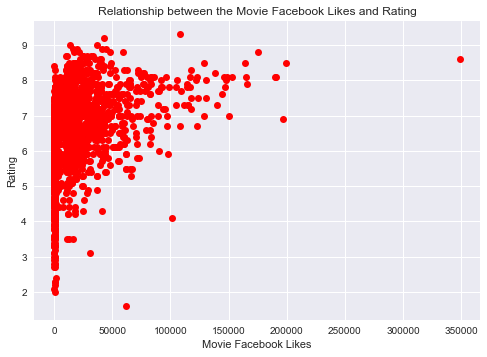

The Pearson Correlation: (0.37433942779071944, 4.4105596968708078e-75)



In [17]:
## Here we will do some simple data analysis on some of the features we selected

## Relationship between the Movie Facebook Likes and Rating
movies_have_facebook = movies_to_use
movies_have_facebook = movies_have_facebook.drop(movies_have_facebook.index[movies_have_facebook.movie_facebook_likes == 0])
xs = list(movies_have_facebook['movie_facebook_likes'])
ys = list(movies_have_facebook['imdb_score'])
print(movies_to_use.info())
print(movies_have_facebook.info())
plt.plot(xs, ys, 'ro')
plt.xlabel('Movie Facebook Likes')
plt.ylabel('Rating')
plt.title('Relationship between the Movie Facebook Likes and Rating')
plt.show()
cor = pearsonr(xs,ys)
print("The Pearson Correlation: " + str(cor))
print()

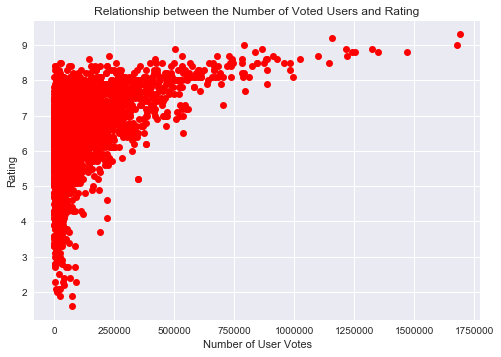

The Pearson Correlation: (0.45810877812094764, 3.7130666771672258e-212)



In [18]:
## Relationship between the Number of Voted Users and Rating
movies_have_user_vote = movies_to_use
movies_have_user_vote = movies_have_user_vote.drop(movies_have_user_vote.index[movies_have_user_vote.num_voted_users == 0])
xs = list(movies_have_user_vote['num_voted_users'])
ys = list(movies_have_user_vote['imdb_score'])
plt.plot(xs, ys, 'ro')
plt.xlabel('Number of User Votes')
plt.ylabel('Rating')
plt.title('Relationship between the Number of Voted Users and Rating')
plt.show()
cor = pearsonr(xs,ys)
print("The Pearson Correlation: " + str(cor))
print()

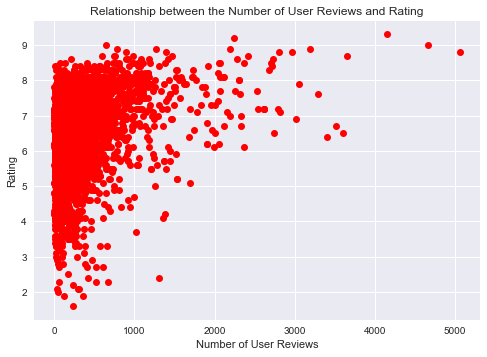

The Pearson Correlation: (0.30993582471878917, 4.2003720571732372e-92)



In [19]:
## Relationship between the Number of User Reviews and Rating
movies_have_user_review = movies_to_use
movies_have_user_review = movies_have_user_review.drop(movies_have_user_review.index[movies_have_user_review.num_user_for_reviews == 0])
xs = list(movies_have_user_review['num_user_for_reviews'])
ys = list(movies_have_user_review['imdb_score'])
plt.plot(xs, ys, 'ro')
plt.xlabel('Number of User Reviews')
plt.ylabel('Rating')
plt.title('Relationship between the Number of User Reviews and Rating')
plt.show()
cor = pearsonr(xs,ys)
print("The Pearson Correlation: " + str(cor))
print()

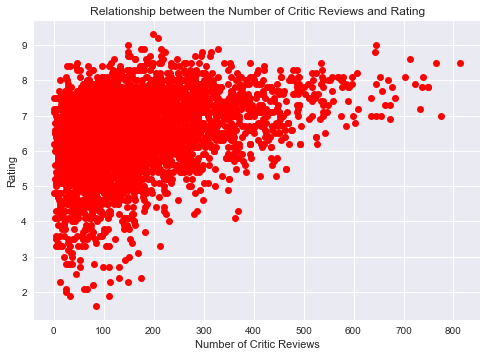

The Pearson Correlation: (0.33678136886564619, 2.0362277101331629e-109)



In [20]:
## Relationship between the Number of Critic Reviews and Rating
movies_have_critic_review = movies_to_use
movies_have_critic_review = movies_have_critic_review.drop(movies_have_critic_review.index[movies_have_critic_review.num_critic_for_reviews == 0])
xs = list(movies_have_critic_review['num_critic_for_reviews'])
ys = list(movies_have_critic_review['imdb_score'])
plt.plot(xs, ys, 'ro')
plt.xlabel('Number of Critic Reviews')
plt.ylabel('Rating')
plt.title('Relationship between the Number of Critic Reviews and Rating')
plt.show()
cor = pearsonr(xs,ys)
print("The Pearson Correlation: " + str(cor))
print()

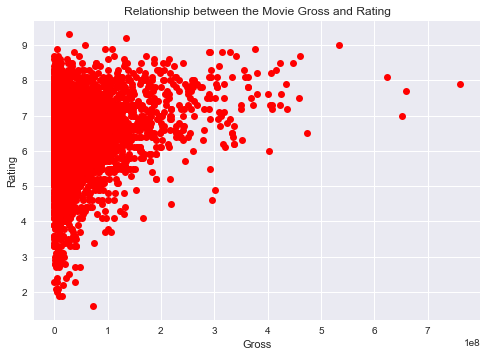

The Pearson Correlation: (0.20100168023483955, 1.1123871815356821e-38)



In [22]:
## Relationship between the Gross and Rating
movie_gross = movies_to_use
movie_gross = movie_gross.drop(movie_gross.index[movie_gross.gross == 0])
xs = list(movie_gross['gross'])
ys = list(movie_gross['imdb_score'])
plt.plot(xs, ys, 'ro')
plt.xlabel('Gross')
plt.ylabel('Rating')
plt.title('Relationship between the Movie Gross and Rating')
plt.show()
cor = pearsonr(xs,ys)
print("The Pearson Correlation: " + str(cor))
print()

In [23]:
## By visulizing the plots and evaluating the correlations
## We found that many of the features we selected have not bad positive correlation with the ratings
## Thus we will start the training

In [24]:
# split the data into train and test sets
movies_to_use['imdb_score']=movies_to_use['imdb_score'].fillna(0.0).astype(int)
data_to_use=list(zip(movies_to_use['movie_facebook_likes'],movies_to_use['num_user_for_reviews'],movies_to_use['cast_total_facebook_likes'],movies_to_use['num_voted_users'],movies_to_use['gross'],movies_to_use['num_critic_for_reviews'],movies_to_use['director_facebook_likes'],movies_to_use['actor_1_facebook_likes'],movies_to_use['actor_2_facebook_likes'],movies_to_use['actor_3_facebook_likes'], movies_to_use['movie_facebook_likes'], movies_to_use['imdb_score']))

imdb_score = list(movies_to_use['imdb_score'])
u = np.array(data_to_use)
print(u)
X=u[:,:-1]
y=u[:,-1]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

[[  3.30000000e+04   3.05400000e+03   4.83400000e+03 ...,   8.55000000e+02
    3.30000000e+04   7.00000000e+00]
 [  0.00000000e+00   1.23800000e+03   4.83500000e+04 ...,   1.00000000e+03
    0.00000000e+00   7.00000000e+00]
 [  8.50000000e+04   9.94000000e+02   1.17000000e+04 ...,   1.61000000e+02
    8.50000000e+04   6.00000000e+00]
 ..., 
 [  4.13000000e+02   1.40000000e+01   6.90000000e+02 ...,   1.33000000e+02
    4.13000000e+02   6.00000000e+00]
 [  6.60000000e+02   9.00000000e+00   2.38600000e+03 ...,   4.89000000e+02
    6.60000000e+02   6.00000000e+00]
 [  4.56000000e+02   8.40000000e+01   1.63000000e+02 ...,   1.60000000e+01
    4.56000000e+02   6.00000000e+00]]
(3284, 11)
(821, 11)
3284
821


In [25]:
from sklearn.svm import SVC
clf=SVC(kernel="rbf")
clf.fit(X_train,y_train)
print("SVM", clf.score(X_test,y_test))

from sklearn import tree
clf=tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
print("DecisionTree",clf.score(X_test,y_test))

from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier()
clf.fit(X_train,y_train)
print("KNeighbors",clf.score(X_test,y_test))

SVM 0.356881851401
DecisionTree 0.390986601705
KNeighbors 0.3215590743


In [25]:
print('From the results shown above, we can see that the accuracies for all three models had improved a lot. The Decision Tree Model performed best among the three')
print('The question is, however, can we do better? And we will try to find it out in our next experiment.')

From the results shown above, we can see that the accuracies for all three models had improved a lot. The Decision Tree Model performed best among the three
The question is, however, can we do better? And we will try to find it out in our next experiment.


In [8]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

In [ ]:
## Phase 2 - Experiment 3
## In order to gain a better understanding of the features of the films
## We will visualize the correlations among all of them in a heatmap-way

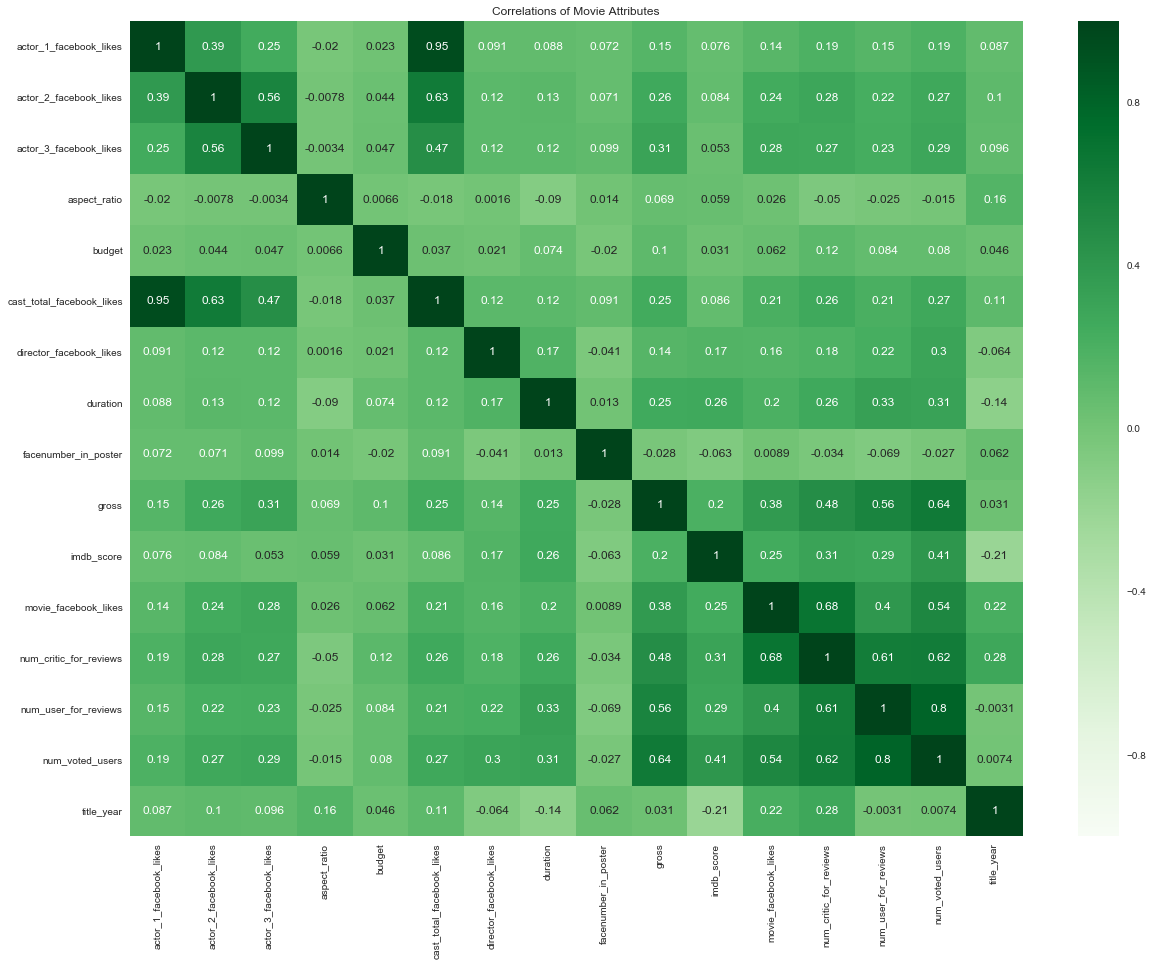

In [22]:
## draw a heatmap of correlations
## get the numerical attributes only
str_attributes = [] 
for colname, colvalue in movies.iteritems():
    if type(colvalue[1]) == str:
         str_attributes.append(colname)          
numerical_attributes = movies.columns.difference(str_attributes) 
numerical_attributes.dropna
movie_attributes = movies[numerical_attributes]

f, ax = plt.subplots(figsize=(20, 15))
plt.title('Correlations of Movie Attributes')
sns.heatmap(movie_attributes.astype(float).corr(), cmap="Greens", annot=True)
plt.show()

In [28]:
print("Based on the heatmap, we can tell that, as opposed to our initial thoughts, the number of Facebook likes of the leading actors does not affect the film rating (almost not at all!) and more interestingly, the film duration which we excluded in our second experiment has shown a relatively strong positive correlation with the rating.")
print()
print("Then we will select the top correlated features in the next experiment to see if there will be any improvement. At the same time, we will not be using some features that we used in last experiment which have little correlation with the rating to avoid possible overfitting problem.")

Based on the heatmap, we can tell that, as opposed to our initial thoughts, the number of Facebook likes of the leading actors does not affect the film rating (almost not at all!) and more interestingly, the film duration which we excluded in our second experiment has shown a relatively strong positive correlation with the rating.

Then we will select the top correlated features in the next experiment to see if there will be any improvement. At the same time, we will not be using some features that we used in last experiment which have little correlation with the rating to avoid possible overfitting problem.


In [47]:
# split the data into train and test sets
movies_to_use2 = movies[['imdb_score','num_critic_for_reviews', 'director_facebook_likes', 'movie_facebook_likes', 'duration', 'gross', 'num_voted_users', 'num_user_for_reviews']]
print(movies_to_use2.shape)
movies_to_use2.tail()
movies_to_use2['imdb_score']=movies_to_use2['imdb_score'].fillna(0.0).astype(int)
movies_to_use2 = movies_to_use2.dropna()
print(movies_to_use2.shape)
movies_to_use2 = movies_to_use2.drop_duplicates()
print(movies_to_use2.shape)
data_to_use2=list(zip(movies_to_use2['duration'], movies_to_use2['movie_facebook_likes'], movies_to_use2['num_user_for_reviews'], movies_to_use2['num_voted_users'], movies_to_use2['gross'], movies_to_use2['num_critic_for_reviews'], movies_to_use2['director_facebook_likes'], movies_to_use2['imdb_score']))
imdb_score2 = list(movies_to_use2['imdb_score'])
u2 = np.array(data_to_use2)
print(u2)
X2=u2[:,:-1]
y2=u2[:,-1]
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(X2, y2, test_size=0.2, random_state=0)
print(X_train2.shape)
print(X_test2.shape)
print(len(y_train2))
print(len(y_test2))

(5043, 8)
(4151, 8)
(4115, 8)
[[  1.78000000e+02   3.30000000e+04   3.05400000e+03 ...,   7.23000000e+02
    0.00000000e+00   7.00000000e+00]
 [  1.69000000e+02   0.00000000e+00   1.23800000e+03 ...,   3.02000000e+02
    5.63000000e+02   7.00000000e+00]
 [  1.48000000e+02   8.50000000e+04   9.94000000e+02 ...,   6.02000000e+02
    0.00000000e+00   6.00000000e+00]
 ..., 
 [  9.50000000e+01   4.13000000e+02   1.40000000e+01 ...,   1.40000000e+01
    0.00000000e+00   6.00000000e+00]
 [  1.00000000e+02   6.60000000e+02   9.00000000e+00 ...,   1.40000000e+01
    0.00000000e+00   6.00000000e+00]
 [  9.00000000e+01   4.56000000e+02   8.40000000e+01 ...,   4.30000000e+01
    1.60000000e+01   6.00000000e+00]]
(3292, 7)
(823, 7)
3292
823


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
## SVC
from sklearn.svm import SVC
clf2=SVC(kernel="rbf")
clf2.fit(X_train2,y_train2)
print("SVM", clf2.score(X_test2,y_test2))

## Decision Tree
from sklearn import tree
clf2=tree.DecisionTreeClassifier()
clf2.fit(X_train2,y_train2)
print("DecisionTree",clf2.score(X_test2,y_test2))

## K Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier
clf2=KNeighborsClassifier()
clf2.fit(X_train2,y_train2)
print("KNeighbors",clf2.score(X_test2,y_test2))

SVM 0.362089914945
DecisionTree 0.400972053463
KNeighbors 0.3304981774


In [33]:
print("The accracies do improve a little, about 1 percent for all the models (better than nothing)")
print("But it it still not very promising (actually it's not bad at all, considering the small datasize and the fact that there are ten categories (film ratings are from 1-10)).")
print("So the accuracy is not that satisfying. As computer scientists, we will not give up of course; we will compromise.")

The accracies do improve a little, about 1 percent for all the models (better than nothing)
But it it still not very promising (actually it's not bad at all, considering the small datasize and the fact that there are ten categories (film ratings are from 1-10)).
So the accuracy is not that satisfying. As computer scientists, we will not give up of course; we will compromise.


In [33]:
## Phase 2 - Experiment 4
## We will try to classify the movies as great movies (top 25%) or bad movies (bottom 25%)
## We will assing a new feature to the movies: 1 if the film's raing is larger than the 75 percentile and 0 for 25 percentile
## split the data into train and test sets
movies_to_use3 = movies[['num_critic_for_reviews', 'director_facebook_likes', 'movie_facebook_likes', 'duration', 'gross', 'num_voted_users', 'num_user_for_reviews', 'imdb_score']]
print(movies_to_use3.shape)
print(movies_to_use3.tail())
movies_to_use3['imdb_score']=movies_to_use3['imdb_score'].fillna(0.0).astype(int)
movies_to_use3 = movies_to_use3.dropna()
print(movies_to_use3.shape)
movies_to_use3 = movies_to_use3.drop_duplicates()
print(movies_to_use3.shape)
movies_to_use3 = movies_to_use3.dropna()
imdb_scores3 = np.array(movies_to_use3['imdb_score'])
p25 = np.percentile(imdb_scores3, 20)
p75 = np.percentile(imdb_scores3, 80)
print(p25)
print(p75)
percentile = (imdb_scores3 > p75) + (imdb_scores3 < p25)
print(percentile)

(5043, 8)
      num_critic_for_reviews  director_facebook_likes  movie_facebook_likes  \
5038                     1.0                      2.0                    84   
5039                    43.0                      NaN                 32000   
5040                    13.0                      0.0                    16   
5041                    14.0                      0.0                   660   
5042                    43.0                     16.0                   456   

      duration    gross  num_voted_users  num_user_for_reviews  imdb_score  
5038      87.0      NaN              629                   6.0         7.7  
5039      43.0      NaN            73839                 359.0         7.5  
5040      76.0      NaN               38                   3.0         6.3  
5041     100.0  10443.0             1255                   9.0         6.3  
5042      90.0  85222.0             4285                  84.0         6.6  
(4151, 8)
(4115, 8)
5.0
7.0
[False False False ..., F

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
## split to training and test data
data_to_use3 = movies_to_use3[percentile]
imdb_scores4 = list(movies_to_use3['imdb_score'][percentile] > p75)
imdb_scores4 = [int(i) for i in imdb_scores4]
u3 = np.array(data_to_use3)
print(u3)
X3=u3[:,:-1]
y3=u3[:,-1]
X_train3, X_test3, y_train3, y_test3 = cross_validation.train_test_split(X3, imdb_scores4, test_size=0.2, random_state=0)

[[  8.13000000e+02   2.20000000e+04   1.64000000e+05 ...,   1.14433700e+06
    2.70100000e+03   8.00000000e+00]
 [  7.03000000e+02   0.00000000e+00   1.23000000e+05 ...,   9.95415000e+05
    1.72200000e+03   8.00000000e+00]
 [  5.16000000e+02   9.40000000e+01   7.20000000e+04 ...,   2.72670000e+05
    1.02200000e+03   8.00000000e+00]
 ..., 
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   5.00000000e+00
    1.00000000e+00   4.00000000e+00]
 [  7.10000000e+01   1.70000000e+04   0.00000000e+00 ...,   1.26110000e+04
    1.13000000e+02   8.00000000e+00]
 [  3.00000000e+00   6.00000000e+00   1.30000000e+01 ...,   1.43000000e+02
    9.00000000e+00   4.00000000e+00]]


In [39]:
from sklearn.svm import SVC
clf3=SVC(kernel="rbf")
clf3.fit(X_train3,y_train3)
print("SVM", clf3.score(X_test3,y_test3))

from sklearn import tree
clf3=tree.DecisionTreeClassifier()
clf3.fit(X_train3,y_train3)
print("DecisionTree",clf3.score(X_test3,y_test3))

from sklearn.neighbors import KNeighborsClassifier
clf3=KNeighborsClassifier()
clf3.fit(X_train3,y_train3)
print("KNeighbors",clf3.score(X_test3,y_test3))

SVM 0.645454545455
DecisionTree 0.881818181818
KNeighbors 0.718181818182


In [34]:
print("As expected, all three models performed way bettwe than they did before. We could achieve the highest accuracy using the Decision Tree model.")

As expected, all three models performed way bettwe than they did before. We could achieve the highest accuracy using the Decision Tree model.


In [36]:
print("Conclusion: ")
print("The data attributes with higher correlations to the target feature tend to give us better prediction accuracies.")
print("Relatively more attributes would offer better predictions.")
print("The Decision Tree Classifier performed best and possible reasons include: all-numerical-value dataset, small dataset size and data non-linearity.")

Conclusion: 
The data attributes with higher correlations to the target feature tend to give us better prediction accuracies.
Relatively more attributes would offer better predictions.
The Decision Tree Classifier performed best and possible reasons include: all-numerical-value dataset, small dataset size and data non-linearity.


In [37]:
print("Future Work: ")
print("Expanding the dataset both vertically and horizontally (meaning more films and more features).")
print("Using categorical values and not just numerical values to train the data.")
print("Experimenting with more models and classifiers.")
print("Identifying appropriate combination of supporting vectors (film features) that predicts most accurately.")

Future Work: 
Expanding the dataset both vertically and horizontally (meaning more films and more features).
Using categorical values and not just numerical values to train the data.
Experimenting with more models and classifiers.
Identifying appropriate combination of supporting vectors (film features) that predicts most accurately.


In [38]:
print("References and Sources:")
print("Films in this dataset (films.csv) are scraped from www.imdb.com . The dataset is used only in this study and will not be used for commercial purposes.")
print("The www.kaggle.com provides this public data (movie_metadata.csv) for academic use only.")

References and Sources:
Films in this dataset (films.csv) are scraped from www.imdb.com . The dataset is used only in this study and will not be used for commercial purposes.
The www.kaggle.com provides this public data (movie_metadata.csv) for academic use only.
